# (VAD) Velocity Azimuth Display

Argonne National Laboratory

Original code by Scott Collis:

https://github.com/scollis/notebooks/blob/master/DYNAMO%20AIME%20workshop%20workbook.ipynb

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np
import pyart
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def pyart_velocity_correct(norm_coh_power=None,
                           norm_coh_power_value=0.5,
                           gatefilter=None,
                           nyquist_velocity=None):
    if norm_coh_power is None:
        # Copying a field and its shape to use as a
        # norm_coherent_power array with matching shape.
        radar.add_field_like('reflectivity', 'norm_coh_power',
                             radar.fields['reflectivity']['data'].copy(),
                             replace_existing=True)
        # Setting all values to norm_coh_power_value,
        # in the field norm_coh_power.
        (radar.fields['norm_coh_power']['data'])[
            radar.fields['norm_coh_power']['data'] !=
            norm_coh_power_value] = norm_coh_power_value
        norm_coh_power_used = 'norm_coh_power'
    else:
        norm_coh_power_used = norm_coh_power
    
    if gatefilter is none:
        gatefilter = pyart.correct.GateFilter(radar)
        gatefilter.exclude_below(norm_coh_power_used, norm_coh_power_value)
    else:
        gatefilter = gatefilter

    if nyquist_velocity is None:
        nyq = None
        corr_vel = pyart.correct.dealias_region_based(
            radar, vel_field='velocity', keep_original=False,
            gatefilter=gatefilter, nyquist_vel=nyq,
            centered=False)
        radar.add_field('corrected_velocity', corr_vel,
                          replace_existing=True)
    else:
        nyq = nyquist_velocity
        corr_vel = pyart.correct.dealias_region_based(
            radar, vel_field='velocity', keep_original=False,
            gatefilter=gatefilter, nyquist_vel=nyq,
            centered=False)
        radar.add_field('corrected_velocity', corr_vel,
                          replace_existing=True)

In [249]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _interval_mean
    _sd_to_uv
    _vad_calculation

"""

import numpy as np
from pyart.core import HorizontalWindProfile


def velocity_azimuth_display(radar, velocity,
                             z_want=None, gatefilter=None):
    """
    Velocity azimuth display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Heights for where to sample vads from.
        None will result in np.linespace(0, 10000, 100).
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded when
        from the vad calculation.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ----------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology. Swedish Meteorological and Hydrological Institute, Norrkoping.

    """

    speed = []
    angle = []
    heights = []
    z_gate_data = radar.gate_z['data']
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)
    else:
        z_want

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]
        if (index_end - index_start) % 2 == 0:
            print("even, all good")
        else:
            index_end = index_end - 1

        velocities = radar.fields[
            velocity]['data'][index_start:index_end]
        if gatefilter is not None:
            velocities = np.ma.masked_where(
                gatefilter.gate_excluded, velocities)
        #mask=velocities.mask
        #velocities[np.where(mask)]=np.nan
        azimuth = radar.azimuth['data'][index_start:index_end]
        elevation = radar.fixed_angle['data'][i]
        one_level = _vad_calculation(velocities,
                                     azimuth, elevation)
        bad = (np.isnan(one_level['speed']))
        print('max height', z_gate_data[index_start, :][~bad].max(),
              ' meters')
        speed.append(one_level['speed'][~bad])
        angle.append(one_level['angle'][~bad])
        heights.append(z_gate_data[index_start, :][~bad])

    speed_array = np.concatenate(speed)
    angle_array = np.concatenate(angle)
    height_array = np.concatenate(heights)
    arg_order = height_array.argsort()
    speed_ordered = speed_array[arg_order]
    height_ordered = height_array[arg_order]
    angle_ordered = angle_array[arg_order]
    print(height_ordered.max())
    u_ordered, v_ordered = _sd_to_uv(speed_ordered, angle_ordered)
    u_mean = _interval_mean(u_ordered, height_ordered, z_want)
    v_mean = _interval_mean(v_ordered, height_ordered, z_want)
    u_mean = np.ma.masked_invalid(u_mean)
    v_mean = np.ma.masked_invalid(v_mean)
    vad = HorizontalWindProfile.from_u_and_v(z_want, u_mean,
                                             v_mean)
    return vad


def _interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z. """
    delta = wanted_z[1] - wanted_z[0]
    pos_lower = [np.argsort((current_z - (
        wanted_z[i] - delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    pos_upper = [np.argsort((current_z - (
        wanted_z[i] + delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    mean_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                            for i in range(len(pos_upper))])
    return mean_values


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return (np.sin(direction) * speed), (np.cos(direction) * speed)


def _vad_calculation(velocity_field, azimuth, elevation):
    """ Calculates VAD for a scan, returns speed and angle
    outdic = vad_algorithm(velocity_field, azimuth, elevation)
    velocity_field is a 2D array, azimuth is a 1D array,
    elevation is a number.
    All in degrees, m outdic contains speed, angle, variance. """
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))

    # Line below needs to be changed to 'is not' expression.
    count = np.sum(np.isnan(sumv) == False, 0)

    aa = count < 8
    vals[:, aa] = 0
    vals2[:, aa] = 0
    count = np.float64(count)
    count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) // (2 * count)])
    count[aa] = 0

    cminusu_mcos = np.zeros((nrays, nbins))
    cminusu_msin = np.zeros((nrays, nbins))
    sincos = np.zeros((nrays, nbins))
    sin2 = np.zeros((nrays, nbins))
    cos2 = np.zeros((nrays, nbins))

    for i in range(nbins):
        cminusu_mcos[:, i] = cosaz * (velocity_field[:, i] - u_m[:, i])
        cminusu_msin[:, i] = sinaz * (velocity_field[:, i] - u_m[:, i])
        sincos[:, i] = sinaz * cosaz
        sin2[:, i] = sinaz**2
        cos2[:, i] = cosaz**2

    cminusu_mcos[vals2] = np.nan
    cminusu_msin[vals2] = np.nan
    sincos[vals2] = np.nan
    sin2[vals2] = np.nan
    cos2[vals2] = np.nan
    sumcminu_mcos = np.nansum(cminusu_mcos, 0)
    sumcminu_msin = np.nansum(cminusu_msin, 0)
    sumsincos = np.nansum(sincos, 0)
    sumsin2 = np.nansum(sin2, 0)
    sumcos2 = np.nansum(cos2, 0)
    b_value = (sumcminu_mcos - (sumsincos*sumcminu_msin / sumsin2)) / (
        sumcos2 - (sumsincos**2) / sumsin2)
    a_value = (sumcminu_msin - b_value*sumsincos) / sumsin2
    speed = np.sqrt(a_value**2 + b_value**2) / np.cos(
        np.deg2rad(elevation))
    angle = np.arctan2(a_value, b_value)
    return {'speed': speed, 'angle': angle}

max height: 707.136208968
max height 707.136208968  meters
707.136208968


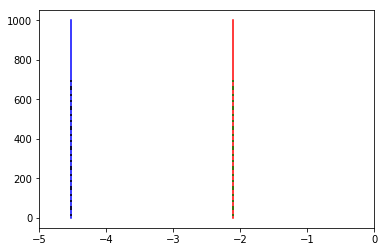

Height
[  0.         10.1010101  20.2020202  30.3030303  40.4040404]
[  0.         10.1010101  20.2020202  30.3030303  40.4040404]
[  959.5959596   969.6969697   979.7979798   989.8989899  1000.       ]
[  959.5959596   969.6969697   979.7979798   989.8989899  1000.       ]
u_wind:
[-2.11309131 -2.11309131 -2.11309131 -2.11309131 -2.11309131]
[-- -2.1130913186039346 -2.1130913186039346 -- -2.1130913186039346]
[-2.11309131 -2.11309131 -2.11309131 -2.11309131 -2.11309131]
[-- -- -- -- --]
v_wind:
[-4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894
 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -4.53153894 -

In [251]:
# create a profile of 100 heights up to 500 m with 5 m/s winds at 25 degrees
height = np.linspace(0, 1000, 100)
speed = np.ones_like(height) * 5
direction = np.ones_like(height) * 25
profile = pyart.core.HorizontalWindProfile(height, speed, direction)


# simulate a single sweep radar with a velocity field from the profile
test_radar = pyart.testing.make_target_radar()
test_radar.elevation['data'][:] = 45.0
test_radar.fixed_angle['data'][:] = 45.0
print("max height:", test_radar.gate_z['data'].max())
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel, replace_existing=True)

# perform a VAD retrieval
vad = velocity_azimuth_display(
    test_radar, 'velocity', z_want=height, gatefilter=None)

# plot the original winds and the retrieved winds
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(profile.u_wind, profile.height, 'r-')
ax.plot(profile.v_wind, profile.height, 'b-')

ax.plot(vad.u_wind, vad.height, 'g--')
ax.plot(vad.v_wind, vad.height, 'k--')

ax.set_xlim(-5, 0)
plt.show()

# print out the results
print("Height")
print(profile.height[:5])
print(vad.height[:5])
print(profile.height[-5:])
print(vad.height[-5:])

print("u_wind:")
print(profile.u_wind[:5])
print(vad.u_wind[:5])
print(profile.u_wind[-5:])
print(vad.u_wind[-5:])

print("v_wind:")
print(profile.v_wind)
print(vad.v_wind)
#print(profile.v_wind[-5:])
#print(vad.v_wind[-5:])

print("speed:")
print(profile.speed[:5])
print(vad.speed[:5])

print("direction:")
print(profile.direction[:5])
print(vad.direction[:5])

In [252]:
test_radar = pyart.io.read(pyart.testing.NEXRAD_ARCHIVE_MSG1_FILE)
new_radar = test_radar.extract_sweeps([4])
radar_sweep = myradar.extract_sweeps([5])
height = np.linspace(50, 10766, 101)

print("max height:", new_radar.gate_z['data'][0].max())

# perform a VAD retrieval
vad_test = velocity_azimuth_display(
    radar_sweep, 'velocity', z_want=height, gatefilter=None)
# print out the results
print("Height")
print(vad_test.height)


print("u_wind:")
print(vad_test.u_wind)

print("v_wind:")
print(vad_test.v_wind)

print("speed:")
print(vad_test.speed)

print("direction:")
print(vad_test.direction)

max height: 32085.2190865
max height 23349.2962065  meters
23349.2962065
Height
[    50.      157.16    264.32    371.48    478.64    585.8     692.96
    800.12    907.28   1014.44   1121.6    1228.76   1335.92   1443.08
   1550.24   1657.4    1764.56   1871.72   1978.88   2086.04   2193.2
   2300.36   2407.52   2514.68   2621.84   2729.     2836.16   2943.32
   3050.48   3157.64   3264.8    3371.96   3479.12   3586.28   3693.44
   3800.6    3907.76   4014.92   4122.08   4229.24   4336.4    4443.56
   4550.72   4657.88   4765.04   4872.2    4979.36   5086.52   5193.68
   5300.84   5408.     5515.16   5622.32   5729.48   5836.64   5943.8
   6050.96   6158.12   6265.28   6372.44   6479.6    6586.76   6693.92
   6801.08   6908.24   7015.4    7122.56   7229.72   7336.88   7444.04
   7551.2    7658.36   7765.52   7872.68   7979.84   8087.     8194.16
   8301.32   8408.48   8515.64   8622.8    8729.96   8837.12   8944.28
   9051.44   9158.6    9265.76   9372.92   9480.08   9587.24   9694.4


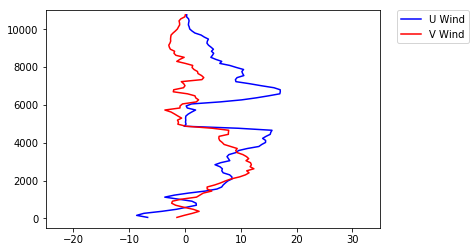

In [253]:
# Without in velocity_azimuth_display function:      
#  mask=velocities.mask
#  velocities[np.where(mask)]=np.nan
fig = plt.figure()
plt.plot(vad_test.u_wind, vad_test.height, 'b-', label='U Wind')
plt.plot(vad_test.v_wind, vad_test.height, 'r-', label='V Wind')
plt.xlim(-25, 35)
plt.ylim(-500, 11000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

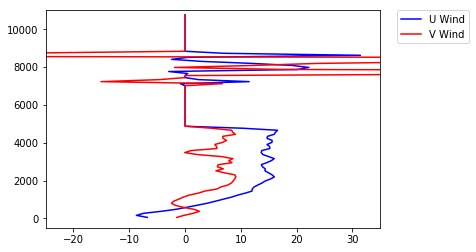

In [194]:
# Within velocity_azimuth_display function:      
#  mask=velocities.mask
#  velocities[np.where(mask)]=np.nan
fig = plt.figure()
plt.plot(vad_test.u_wind, vad_test.height, 'b-', label='U Wind')
plt.plot(vad_test.v_wind, vad_test.height, 'r-', label='V Wind')
plt.xlim(-25, 35)
plt.ylim(-500, 11000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [214]:
for i in range(len(test_radar.sweep_start_ray_index['data'])):
    index_start = test_radar.sweep_start_ray_index['data'][i]
    index_end = test_radar.sweep_end_ray_index['data'][i]
    if (index_end - index_start) % 2 == 0:
        print("even, all good")
    else:
        index_end = index_end - 1

    velocity_field = test_radar.fields[
        'velocity']['data'][index_start:index_end]
    azimuth = test_radar.azimuth['data'][index_start:index_end]
    elevation = test_radar.fixed_angle['data'][i]
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))
    # Jonathan, still can't get == 0 switched to is not the expression.
    # Have errors, I apologize I might be overthinking how to accomplish that.
    count = np.sum(np.isnan(sumv) == False, 0)
    aa = count < 8
    vals[:, aa] = 0
    vals2[:, aa] = 0
    count = np.float64(count)
    count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) / (2 * count)])
    count[aa] = 0
    print(u_m)

[[ 0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573  0.01767573  0.01767573  0.01767573  0.01767573
   0.01767573  0.01767573]]


In [250]:
filename = '/home/zsherman/training_exercises/data/KLOT20130417_235520_V06.gz'
myradar = pyart.io.read(filename)

In [69]:
myradar.sweep_start_ray_index['data']

array([   0,  720, 1440, 2160, 2880, 3600, 4320, 4680, 5040, 5400, 5760,
       6120, 6480, 6840, 7200, 7560, 7920], dtype=int32)

In [179]:
ray_start = []
ray_end = []

for i in range(len(myradar.sweep_start_ray_index['data'])):
    index_start = myradar.sweep_start_ray_index['data'][i]
    index_end = myradar.sweep_end_ray_index['data'][i]

    ray_start.append(index_start)
    ray_end.append(index_end)
ray_start = np.array(ray_start)
ray_start
ray_end

[719,
 1439,
 2159,
 2879,
 3599,
 4319,
 4679,
 5039,
 5399,
 5759,
 6119,
 6479,
 6839,
 7199,
 7559,
 7919,
 8279]

In [34]:
myradar.azimuth

{'axis': 'radial_azimuth_coordinate',
 'comment': 'Azimuth of antenna relative to true north',
 'data': array([ 174.24316406,  174.72106934,  175.25390625, ...,  213.51379395,
         214.49981689,  215.49407959]),
 'long_name': 'azimuth_angle_from_true_north',
 'standard_name': 'beam_azimuth_angle',
 'units': 'degrees'}

In [32]:
myradar.fixed_angle['data']

array([  0.48339844,   0.48339844,   0.87890625,   0.87890625,
         1.31835938,   1.31835938,   1.80175781,   2.41699219,
         3.12011719,   3.99902344,   5.09765625,   6.41601562,
         7.99804688,  10.01953125,  12.48046875,  15.60058594,  19.51171875], dtype=float32)

In [9]:
vad = velocity_azimuth_display(myradar, 'velocity')

max height 16378.3196353  meters
max height 16664.336786  meters
max height 18644.1409849  meters
max height 19831.749484  meters
max height 22733.8708519  meters
max height 23349.2962065  meters
max height 28314.2167915  meters
max height 31848.3092148  meters
max height 36936.2556392  meters
max height 44031.5646064  meters
max height 52728.7671706  meters
max height 62490.3668599  meters
max height 76743.0034827  meters
max height 91638.9944802  meters
max height 112526.51153  meters
max height 134714.181605  meters
max height 163740.607128  meters


In [28]:
corr_vel = pyart.correct.dealias_region_based(
    myradar, vel_field='velocity', keep_original=False, 
    gatefilter=None, nyquist_vel=None, centered=True)
myradar.add_field('corrected_velocity', corr_vel,
                  replace_existing = True)
vad_corrected = velocity_azimuth_display(myradar,
                                         'corrected_velocity',
                                         z_count=101)

max height 16378.3196353  meters
max height 16664.336786  meters
max height 18644.1409849  meters
max height 19831.749484  meters
max height 22733.8708519  meters
max height 23349.2962065  meters
max height 28314.2167915  meters
max height 31848.3092148  meters
max height 36936.2556392  meters
max height 44031.5646064  meters
max height 52728.7671706  meters
max height 62490.3668599  meters
max height 76743.0034827  meters
max height 91638.9944802  meters
max height 112526.51153  meters
max height 134714.181605  meters
max height 163740.607128  meters


In [30]:
vad.speed

array([ 1.88288726,  0.86016533,  1.12002044,  1.81106364,  2.04469912,
        2.48172437,  2.90231224,  3.86181863,  4.75337025,  5.51197815,
        6.0330035 ,  6.44692266,  7.03198106,  7.6739984 ,  7.99057773,
        8.47618057,  8.71327211,  8.81045014,  9.1957126 ,  9.20648551,
        9.72271189,  9.65639762,  8.76392175,  8.66674489,  8.57776901,
        8.459111  ,  8.22434225,  8.09939404,  8.11504363,  8.39767749,
        9.13443443,  9.23677296,  7.97793043,  7.76802828,  7.65301287,
        7.23241781,  7.18284373,  7.00001129,  7.23638352,  7.00692738,
        7.77117481,  7.48225215,  8.66405375,  8.20142139,  8.20391146,
        8.49184376,  8.40315863,  8.48070603,  8.48254191,  8.44062985,
        8.4188897 ,  7.85081286,  8.03046261,  8.29083845,  8.05622144,
        8.6005199 ,  8.59951314,  9.38521384,  8.84579231,  7.89980691,
        7.93838037,  7.77571947,  6.78064494,  6.90131734,  6.30957685,
        6.71875707,  5.32581301,  5.53492174,  5.06371933,  5.08

In [34]:
vad.u_wind

array([ 1.02861839, -0.15651681, -1.067073  , -1.44928876, -1.20451048,
       -0.65907686,  0.70999025,  1.66796268,  2.52933849,  3.43875201,
        4.12525984,  4.61166223,  5.34382439,  5.96453165,  6.37940731,
        6.50285137,  6.71418311,  6.60905247,  7.11096486,  7.30057627,
        7.6180045 ,  7.59178412,  7.00250278,  6.56384896,  6.37307028,
        6.17344703,  5.80289492,  5.55271026,  5.40983771,  5.67875337,
        6.03524697,  5.86105151,  5.24969842,  4.81906074,  4.29069527,
        4.18629419,  4.19708279,  4.27475747,  4.79035276,  4.84632915,
        5.54640544,  5.31084411,  5.90998208,  5.5818397 ,  5.29327136,
        5.12596976,  5.09181406,  4.99799896,  4.77305366,  4.83028545,
        4.97983656,  4.82106597,  5.11648326,  5.44790957,  5.38177983,
        5.44768839,  5.24219215,  5.39009198,  4.84654047,  4.15815863,
        3.82405183,  3.35639534,  2.72491856,  2.8167996 ,  2.65535148,
        3.01717375,  2.02187565,  2.03364539,  1.83248566,  1.94

In [35]:
vad.v_wind

array([-1.57708866, -0.84580546,  0.34029546,  1.08605414,  1.65225573,
        2.39260811,  2.81413045,  3.48303655,  4.02454662,  4.30777062,
        4.40219973,  4.50503976,  4.57080938,  4.82852085,  4.81170395,
        5.43677856,  5.55345442,  5.82618719,  5.83054962,  5.60900718,
        6.0412858 ,  5.96748094,  5.26984622,  5.65935985,  5.7412626 ,
        5.78317479,  5.82805423,  5.89640506,  6.04876757,  6.18649718,
        6.85665271,  7.13905105,  6.00733223,  6.0925296 ,  6.33707662,
        5.89769517,  5.82904281,  5.54315854,  5.42381479,  5.06064473,
        5.44321087,  5.27058176,  6.33545099,  6.00885832,  6.26780995,
        6.77021746,  6.68479651,  6.85145103,  7.01223759,  6.92189098,
        6.7881464 ,  6.19617507,  6.1895015 ,  6.24966267,  5.99492701,
        6.655196  ,  6.81696764,  7.68304284,  7.39993832,  6.71689408,
        6.95661631,  7.01401623,  6.20902284,  6.30030325,  5.72362373,
        6.00319574,  4.92709885,  5.1477806 ,  4.72051371,  4.69

In [36]:
vad.direction

array([ 326.88656003,   10.48402119,  107.6877691 ,  126.84680489,
        143.90758754,  164.59904752,  194.1599201 ,  205.5889104 ,
        212.14845265,  218.59921932,  223.13990182,  225.67006014,
        229.45816549,  231.00848096,  232.97436952,  230.10232916,
        230.40507125,  228.60232364,  230.65037483,  232.46505339,
        231.58462184,  231.83107355,  233.03612104,  229.23204168,
        227.98548389,  226.86950934,  224.8760617 ,  223.28053534,
        221.80850211,  222.54966494,  221.35433474,  219.38547096,
        221.14961931,  218.34324387,  214.10106535,  215.36784415,
        215.75500043,  217.63859023,  221.45117676,  223.76072516,
        225.53800235,  225.21800951,  223.01005236,  222.89009214,
        220.18165682,  217.13064458,  217.2965493 ,  216.11001654,
        214.24213336,  214.90839217,  216.26405946,  217.88546067,
        219.5784627 ,  221.07907211,  221.91503081,  219.3024414 ,
        217.5599887 ,  215.05184602,  213.22252785,  211.75998